In [1]:
# SV Survey as modified main survey

In [42]:
import os
import copy
import warnings
import logging
import sqlite3
import numpy as np
import healpy as hp
import skyproj
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

from zoneinfo import ZoneInfo

timezone = "Chile/Continental"
tz = ZoneInfo(timezone)
tz_utc = ZoneInfo("UTC")

# For making airmass plots, if desired
from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass

from rubin_scheduler.scheduler.utils import generate_all_sky, get_current_footprint, Footprint

from rubin_scheduler.scheduler import sim_runner

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.schedulers import SimpleBandSched, CoreScheduler
from rubin_scheduler.scheduler.surveys import FieldSurvey
import rubin_scheduler.scheduler.basis_functions as basis_functions
import rubin_scheduler.scheduler.detailers as detailers

from rubin_scheduler.scheduler import features
from rubin_scheduler.scheduler.basis_functions import BaseBasisFunction
from rubin_scheduler.utils import _angular_separation, Site
from rubin_scheduler.scheduler.detailers import BaseDetailer

from rubin_scheduler.scheduler.utils import SchemaConverter, run_info_table
import rubin_sim.maf.plots as plots
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.metric_bundles as mb
from rubin_sim.maf.db import ResultsDb

from custom_step import PerFilterStep

# If running on the USDF, find rubin_scheduler data here:
if "usdf" in os.getenv("EXTERNAL_INSTANCE_URL", ""):
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

import sv_support as sv

In [3]:
run_name = 'sv_ms_4'
out_dir = run_name

In [4]:
nside = 32
survey_info = sv.survey_times(verbose=True)

Survey start 2025-06-15 12:00:00.000
Survey end 2025-09-15T12:00:00.000
for a survey length of (nights) 92
91.07114195649046 781.4164783477318 0.11654622660256167
171.06706417829264 781.4164783477318 0.21891919215730626
215.55753507697955 781.4164783477318 0.27585486235555945
found overlap
found overlap
Max length of night 11.929420676082373 min length of night 10.37283631414175
Total nighttime 1048.1677196994424, total downtime 425.98779871553415, available time 622.1799209839082


(0.9, 1.5)

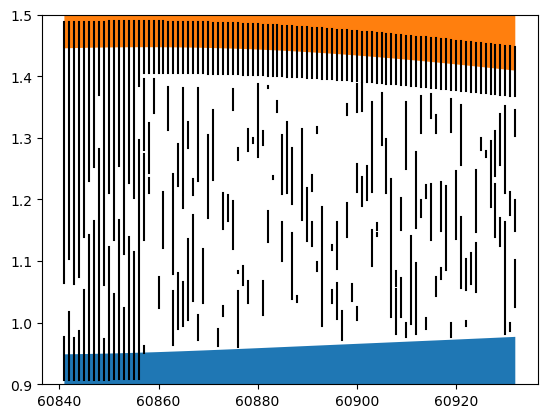

In [5]:
for start, end in survey_info['downtimes']:
    x = np.floor(start - 0.5)
    plt.plot((x, x), (start - x, end - x) , color='k') 
x = np.floor(survey_info['sunsets'] - 0.5)
y = survey_info['sunsets'] - x
plt.fill_between(x, 0.8, y)
x = np.floor(survey_info['sunrises'] - 0.5)
y = survey_info['sunrises'] - x
plt.fill_between(x, y, 1.6)
plt.ylim(0.9, 1.5)

In [6]:
# Define footprint
# survey_info = sv.survey_footprint(survey_info, verbose=True)
# hp.mollview(survey_info['sky']['map'])
# hp.graticule()

In [7]:
from all_early import *

parser = sched_argparser()
args = parser.parse_args(args=[])
args.setup_only = True
args.no_too = True
args.dbroot = "example_"
args.outDir = "."
args.nside = nside
args.mjd_start = survey_info['survey_start'].mjd
args.survey_length = survey_info['survey_length'] 
args.nexp = 1

scheduler = gen_scheduler(args)

Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a


/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/base_survey.py:545: FutureWarning: setting dither to bool deprecated, swapping to dither='night'
  warnings.warn("setting dither to bool deprecated, swapping to dither='night'", FutureWarning)


            night        
            count nunique
target_name              
DD:ECDFS     1240      10
DD:EDFS_a     549       9
DD:EDFS_b     549       9
DD:ELAISS1   2356      19
DD:XMM_LSS   1736      14


,ID
count,44.000000
mean,146.136364
std,54.721957
min,122.000000
25%,124.000000
50%,124.000000
75%,124.000000
max,370.000000


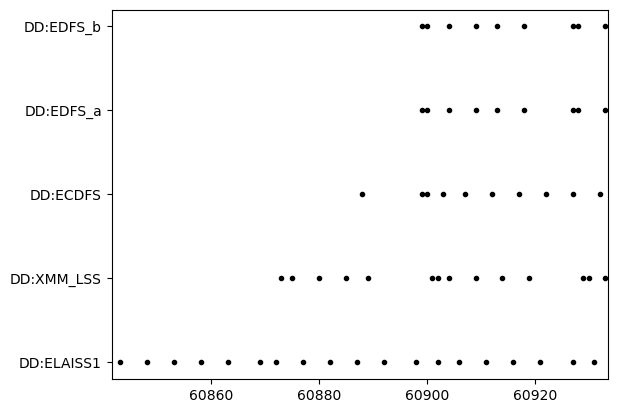

In [8]:
df = pd.DataFrame(np.concatenate([scheduler.survey_lists[0][0].obs_wanted, scheduler.survey_lists[0][1].obs_wanted]))
df['night'] = np.floor(df['mjd'] - 0.5)
start = survey_info['survey_start'].mjd
end = survey_info['survey_end'].mjd
df = df.query("night >= @start and night <= @end")
x= df.groupby(['night', 'target_name']).agg({'mjd': 'first', 'alt_min': 'first', 'alt_max': 'first'}).reset_index()
plt.plot(x.night, x.target_name, 'k.')
plt.xlim(survey_info['survey_start'].mjd, survey_info['survey_end'].mjd)
print(df.groupby('target_name').agg({'night':('count', 'nunique')}))
df.groupby('night').agg({'ID':'count'}).describe()

In [9]:
#scheduler.survey_lists.append(ddf_surveys)
scheduler.survey_lists

[[<ScriptedSurvey survey_name='' at 0x16a213bb0>,
  <ScriptedSurvey survey_name='' at 0x16a213950>],
 [<LongGapSurvey survey_name='Long Gap (Long Gap blob_long, gr + Triplet)' at 0x16a1f7770>,
  <LongGapSurvey survey_name='Long Gap (Long Gap blob_long, ri + Triplet)' at 0x16a609950>,
  <LongGapSurvey survey_name='Long Gap (Long Gap blob_long, iz + Triplet)' at 0x16a60b390>],
 [<BlobSurvey survey_name='templates, u' at 0x16a4e4f50>,
  <BlobSurvey survey_name='templates, g' at 0x16a4e5950>,
  <BlobSurvey survey_name='templates, r' at 0x16a4e60d0>,
  <BlobSurvey survey_name='templates, i' at 0x16a4e6210>,
  <BlobSurvey survey_name='templates, z' at 0x16a4e6350>,
  <BlobSurvey survey_name='templates, y' at 0x16a4e6490>],
 [<BlobSurvey survey_name='pair_33, ug' at 0x16a559310>,
  <BlobSurvey survey_name='pair_33, ur' at 0x16a4e4190>,
  <BlobSurvey survey_name='pair_33, gr' at 0x16a4e4410>,
  <BlobSurvey survey_name='pair_33, ri' at 0x16a4e4550>,
  <BlobSurvey survey_name='pair_33, iz' at 0x

In [10]:
# What does the observatory look like?  (remember to set this back up if you change the downtimes)
setup_observatory = False
try:
    model_obs
except:
    setup_observatory = True 
    
if setup_observatory:
    model_obs = sv.setup_observatory(survey_info)

observatory = copy.deepcopy(model_obs)

# Filter scheduler - simply changes between ugriz and grizy depending on lunar phase
fs = SimpleBandSched(illum_limit=40)

In [11]:
%%capture sched_log
# Catch the RuntimeWarning if calc_reward returns all nans
rewards = False
scheduler.keep_rewards=rewards

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    vals = sim_runner(
        observatory,
        scheduler,
        band_scheduler=fs,
        sim_start_mjd=survey_info['survey_start'].mjd,
        sim_duration=survey_info['survey_length'],
        record_rewards=rewards,
        verbose=True,
    )
observatory = vals[0]
scheduler = vals[1]
observations = vals[2]
if len(vals) == 5:
    rewards = vals[3]
    obs_rewards = vals[4]

In [12]:
# sched_log.stderr

In [13]:
# If more debugging at a particular time is desired

# nside, scheduler = get_scheduler()
# observatory = get_ideal_model_observatory(nside=nside, dayobs = day_obs, wind_speed=0, wind_direction=0)
# observatory.observatory.setup_camera(band_changetime=5.0, maxspeed=1.5, shutter_2motion_min_time=0.0)
# observatory.observatory.setup_telescope(altitude_maxspeed=1.5, azimuth_maxspeed=1.5, settle_time=40.0)
# observatory.observatory.setup_dome(azimuth_maxspeed=3.0)
# observatory.mjd = sunset.mjd

conditions = observatory.return_conditions()

# test_observations = []
# scheduler.update_conditions(conditions)
# obs = scheduler.request_observation(mjd=observatory.mjd, whole_queue=True)
# if obs is not None:
#     for o in obs:
#         observation, new_night = observatory.observe(o)
#         if observation is not None:
#             scheduler.add_observation(observation)
#             test_observations += [observation]

# Or look at survey basis functions at a particular time
# conditions = observatory.return_conditions()
# for ti, tier in enumerate(scheduler.survey_lists):
#     print(f"TIER {ti}")
#     for survey in tier:
#         print(survey.survey_name)
#         if survey.survey_name.startswith('Long'):
#             continue
#         for bf in survey.basis_functions:
#             bf_values = bf(conditions)
#             if isinstance(bf_values, float) or isinstance(bf_values, int):
#                 print(bf.label(), bf.check_feasibility(conditions), bf_values)
#             else:
#                 print(bf.label(), bf.check_feasibility(conditions), np.nanmax(bf_values), np.nanmax(bf_values[survey.roi_hpid]))
#         print('total survey reward', np.nanmax(survey.calc_reward_function(conditions)))

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


In [14]:
np.unique(observations['target_name'])

array(['', 'DD:ECDFS', 'DD:EDFS_a', 'DD:EDFS_b', 'DD:ELAISS1',
       'DD:XMM_LSS'], dtype='<U40')

Total night time (hours): 1048.17
Total down time (hours): 425.99
Total available time (hours): 622.18
Total time in observations + slew (hours): 619.69
Unscheduled time (hours): 2.49


Text(0.5, 1.0, 'SV surveys from 2025-06-15 to 2025-09-15')

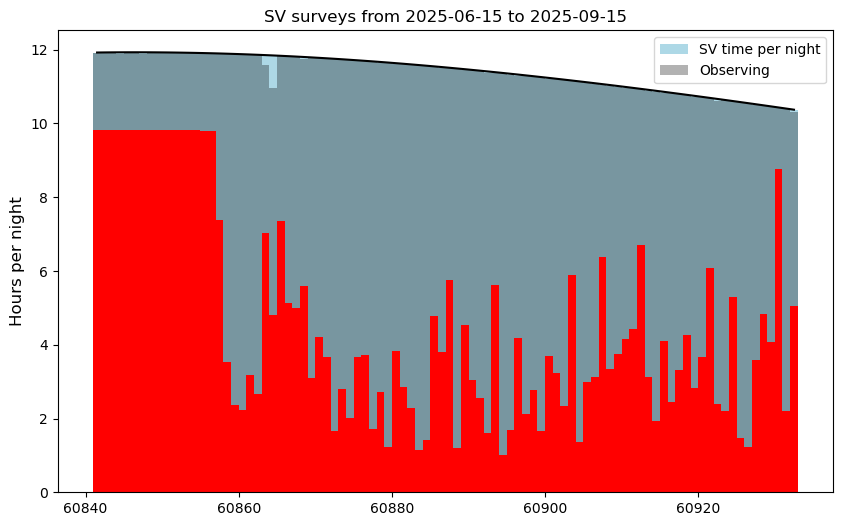

In [15]:
survey_info = sv.count_obstime(observations, survey_info)

plt.figure(figsize=(10,6))
plt.plot(survey_info['dayobsmjd'], survey_info['hours_in_night'], 'k')
w = 1
plt.bar(survey_info['dayobsmjd'], survey_info['downtime_per_night'], width=w, color='r')
plt.bar(survey_info['dayobsmjd'], survey_info['hours_in_night'] - survey_info['downtime_per_night'], bottom=survey_info['downtime_per_night'], width=w,
        color='lightblue', label="SV time per night")
plt.bar(survey_info['dayobsmjd'], survey_info['obs_time_per_night'],  bottom=survey_info['downtime_per_night'], 
        color='k', width=w, alpha=0.3, label='Observing')

plt.legend()
plt.ylabel("Hours per night", fontsize='large')
plt.title(f"SV surveys from {survey_info['survey_start'].iso[0:10]} to {survey_info['survey_end'].iso[0:10]}")

In [16]:
!mkdir $out_dir
visitsdf = sv.save_opsim(filename=os.path.join(out_dir, run_name + '.db'), observatory=observatory, observations=observations)

mkdir: sv_ms_4: File exists


In [37]:
out_dir, run_name

('sv_ms_4', 'sv_ms_4')

In [46]:
necessary = True
if necessary:
    out_dir = 'sv_ms_3'
    run_name = out_dir
    conn = sqlite3.connect(os.path.join(out_dir, run_name + ".db"))
    visitsdf = pd.read_sql("select * from observations", conn)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


np.float64(5130.602053175862)

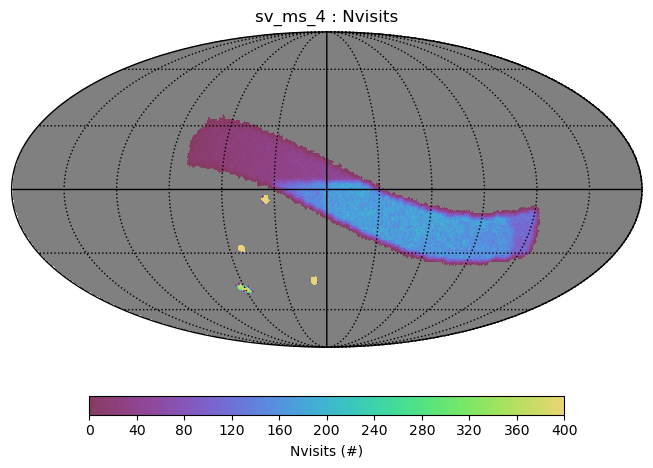

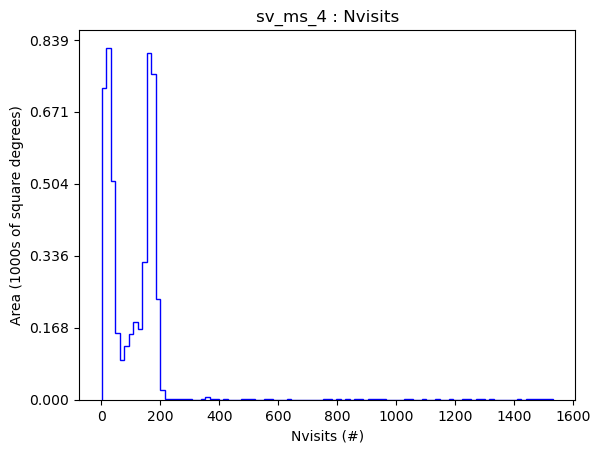

In [18]:
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
sky_slicer = slicers.HealpixSlicer(64)
constraint = ''
plot_dict = {'color_min': 0, 'color_max': 400}
bundle = mb.MetricBundle(m, sky_slicer, constraint, plot_dict=plot_dict, run_name=run_name)
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.to_records())
bundle.plot()
len(bundle.metric_values.compressed()) * hp.nside2pixarea(64, degrees=True)

In [19]:
nvis_band = {}
for b in 'ugrizy':
    m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
    sky_slicer = slicers.HealpixSlicer(64)
    constraint = ''
    plot_dict = {'color_min': 0, 'color_max': 400}
    nvis_band[b] = mb.MetricBundle(m, sky_slicer, constraint, plot_dict=plot_dict, run_name=run_name)
    g = mb.MetricBundleGroup({0: nvis_band[b]}, None, out_dir=out_dir)
    g.run_current(constraint, sim_data=visitsdf.query("band == @b").to_records())
    print(b, len(nvis_band[b].metric_values.compressed()) * hp.nside2pixarea(64, degrees=True))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
u 3216.1732484491913
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
g 4852.795856610966
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
r 4989.600720780387
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
i 5033.243990331367
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
z 4990.440014425598
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
y 3331.156477843121


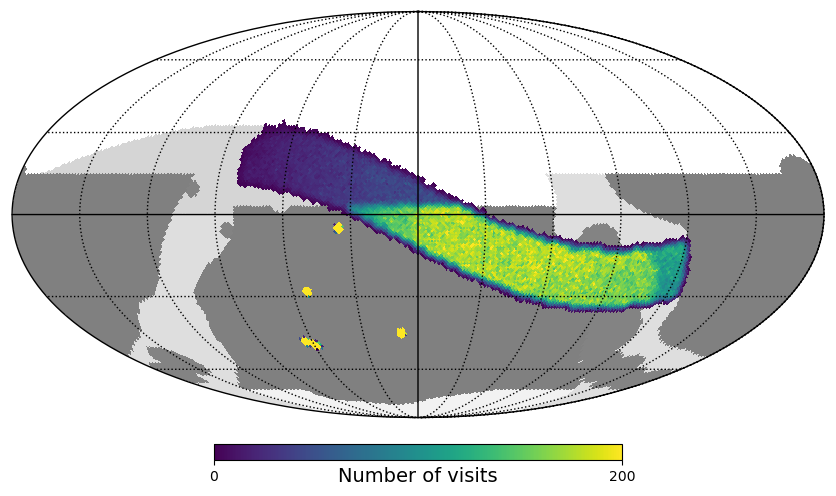

In [33]:
from rubin_scheduler.scheduler.utils import get_current_footprint
fp, labels = get_current_footprint(nside=64)
alpha = np.where(bundle.metric_values.filled(-1) >= 0, 1, fp['r'])
alpha = np.where(alpha > 1, 1, alpha)
hp.mollview(bundle.metric_values.filled(hp.UNSEEN), alpha=alpha, min=0, max=200, title=None, unit='Number of visits')
hp.graticule()

u 7.0
g 11.0
r 24.0
i 26.0
z 22.0
y 27.0


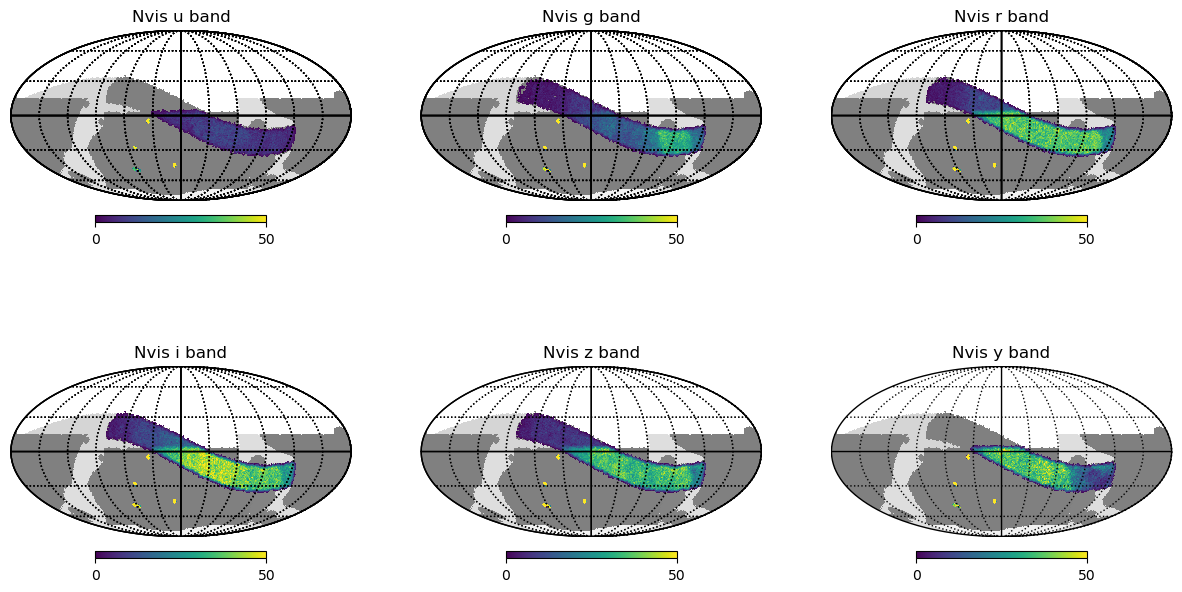

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
i = 0
j = 0
for b in 'ugrizy':
    ax = axes[i][j]
    j += 1
    if j == 3:
        j = 0 
        i = 1
    plt.axes(ax)
    hp.mollview(nvis_band[b].metric_values.filled(hp.UNSEEN), alpha=alpha, min=0, max=50, title=f"Nvis {b} band", hold=True, margins=[0, 0, 0, 0])
    hp.graticule()
for b in 'ugrizy':
    print(b, np.median(nvis_band[b].metric_values.compressed()))

In [22]:
print('Area with > 100 visits', len(np.where(bundle.metric_values.compressed()>100)[0]) * hp.nside2pixarea(64, degrees=True))

Area with > 100 visits 2633.7034586726413


In [23]:
visit_count = visitsdf.groupby(['target_name', 'band']).agg({'observationId': 'count'}).reset_index('band').pivot(columns=['band']).droplevel(level=0, axis=1)[['u', 'g', 'r', 'i', 'z', 'y']]
visit_count['total'] = visit_count.sum(axis=1)
visit_count

band,u,g,r,i,z,y,total
target_name,,,,,,,
,2403,6450,11678,13096,10996,8693,53316
DD:ECDFS,75,150,200,200,225,140,990
DD:EDFS_a,36,56,80,80,96,50,398
DD:EDFS_b,36,56,80,80,96,50,398
DD:ELAISS1,125,251,320,320,384,240,1640
DD:XMM_LSS,175,195,260,260,312,178,1380


Text(0.5, 0, 'airmass')

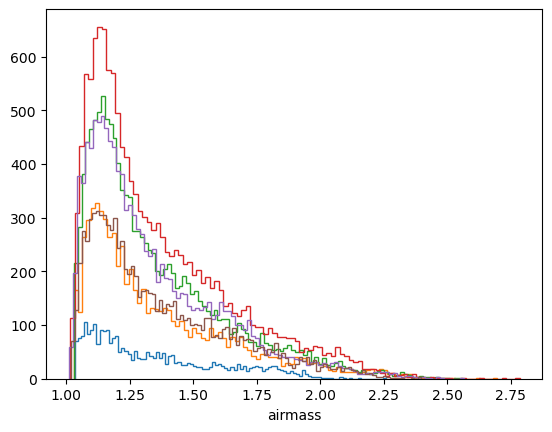

In [24]:
for b in 'ugrizy':
    q = visitsdf.query("band == @b")
    _ = plt.hist(q.airmass, bins=100, histtype='step')
plt.xlabel('airmass')

In [47]:
templates = {}
template_groups = {}
for b in 'ugrizy':
    m = metrics.TemplateTime()
    m.filter_col = m.band_col
    sky_slicer = slicers.HealpixSlicer(128)
    constraint = f"{b} band"
    plot_dict = {'color_min': 0, 'color_max': 400}
    templates[b] = mb.MetricBundle(m, sky_slicer, constraint, plot_dict=plot_dict, run_name=run_name)
    template_groups[b] = mb.MetricBundleGroup({0: templates[b]}, None, out_dir=out_dir)
    template_groups[b].run_current(constraint, sim_data=visitsdf.query("band == @b").to_records())

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


u 2912.3489488827486
g 4249.763372526743
r 4616.534695484022
i 4755.2279703551685
z 4675.285250648804
y 3220.5795400865495


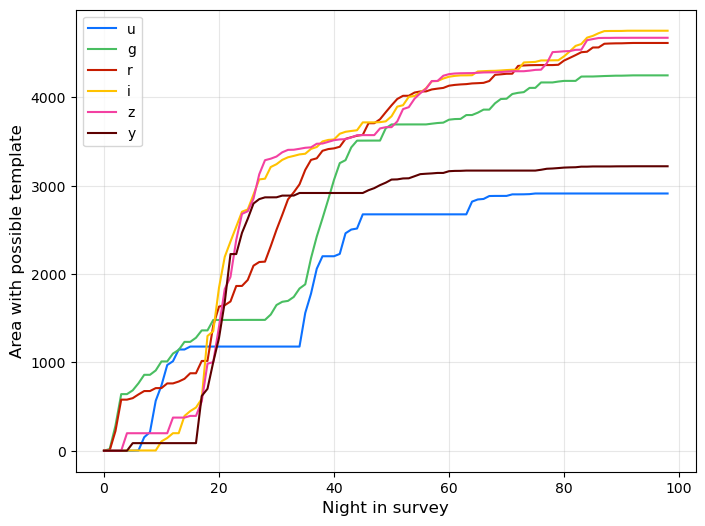

In [26]:
band_colors = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00', 'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}
nights = np.arange(0, 100, 1)
pixarea = hp.nside2pixarea(128, degrees=True)
area_over_time = {}
footprint_area = {}
for b in 'ugrizy':
    k = "TemplateTime_night_template_created"
    counts, bins = np.histogram(template_groups[b].bundle_dict[k].metric_values.compressed(), bins=nights)
    footprint_area[b] = len(template_groups[b].bundle_dict[k].metric_values.compressed()) * pixarea
    area_over_time[b] = counts.cumsum() * pixarea 

plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    plt.plot(nights[:-1], area_over_time[f], color=band_colors[f], label=f)
plt.legend()
plt.xlabel('Night in survey', fontsize='large')
plt.ylabel('Area with possible template', fontsize='large')
plt.grid(True, alpha=0.3)
for b in 'ugrizy':
    print(b, max(area_over_time[b]))#, footprint_area[b])

In [30]:
print("template metric alert # estimate")
for b in 'ugrizy':
    print(b, template_groups[b].bundle_dict['TemplateTime_total_alerts'].metric_values.compressed().sum())

template metric alert # estimate
u 75457129.6621114
g 1107571689.6024158
r 1162372756.945384
i 714304145.239018
z 304409221.5739146
y 58883094.44492842


In [48]:
print("template metric alert # estimate")
for b in 'ugrizy':
    print(b, template_groups[b].bundle_dict['TemplateTime_total_alerts'].metric_values.compressed().sum())

template metric alert # estimate
u 93119350.40806878
g 992190809.1721925
r 1094771225.9831417
i 714777520.5182654
z 286107516.2469503
y 63458588.14362915
